# 2-component model testing

In [1]:
using Plots # WARNING: the "plot" parameter will overwrite the plot function
using BenchmarkTools
using LaTeXStrings
using Distributions
using Statistics
using Printf
using Distributed
import Random: seed!
using SpecialFunctions
using NumericalIntegration
using LinearAlgebra
using NPZ
include("AffineInvariantMCMC.jl")

save_chain (generic function with 1 method)

In [46]:
# Adjust parameters relative to imported parameter file

include("../params.py")

vmin = Float64(vmin)
vesc_guess = Float64(vesc_guess)
sigmapriormin = Float64(sigmapriormin)
kpriormax = Float64(kpriormax)
fs_sausage_min = Float64(fs_sausage_min)
fs_sausage_max = Float64(fs_sausage_max)
inverse_vesc_prior = Bool(inverse_vesc_prior)
outlier = Bool(outlier)
sausage = Bool(sausage)
random_samples = Bool(random_samples)
edr3 = Bool(edr3)
fire = Bool(fire)

if inverse_vesc_prior
    vesc_guess = 1.0 / vesc_guess
end


### Sample from distribution to obtain data which we will fit via MCMC

We generate data with a specific escape velocity and $k$ to use in our parameter fit later

In [29]:
target_vesc = 500.0
target_k = 3.5
target_frac = log(0.01)
target_sigma = log(1000.0)
target_ks = 1.0
target_fs = 0.6
target_x = [target_vesc,target_k]


#num_samples = 2000
#target_data = generate_samples(num_samples,powerlaw_inverse_CDF,target_x);

In [5]:
target_data = npzread("speed.npy")
target_data_err = npzread("speed_error.npy")

target_data_err'

1×2000 adjoint(::Vector{Float64}) with eltype Float64:
 19.0188  22.4413  16.2253  18.2428  …  17.2787  19.2584  21.8595  21.6293

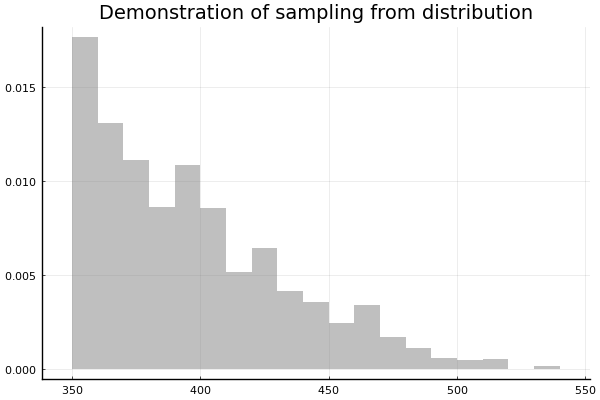

In [6]:
pyplot()

histogram(target_data[target_data .< 550.0], normed = true,
                    bins = 25,
                    title = "Demonstration of sampling from distribution",
                    alpha = 0.5,
                    bar_width = 10,
                    linewidth = 0,
                    color = "gray" ,
                    label = ""
                    )

#= v_test = collect(1:1:550)
plot!(v_test, map(v -> powerlaw_PDF(v,[550.0,3.0]) , v_test) ,
                    linewidth = 2,
                    #color = "red",
                    label = L"v_{esc}=550,~k=3"
                    ) =#

In [ ]:
#target_data_err = verrcut.*target_data
target_data_err'

In [ ]:
target_data'

In [7]:
mask = target_data .> vmin
target_data = target_data[mask]
target_data_err = target_data_err[mask];
target_data'

1×2000 adjoint(::Vector{Float64}) with eltype Float64:
 365.127  434.785  356.71  373.577  …  372.713  378.784  425.177  451.796

# Define MCMC functions and parameters

In [8]:
include("functions_MCMC.jl")

lnprob (generic function with 10 methods)

# Use MCJulia to perform sampling

### Parameters and initial conditions for walkers

In [9]:
# Parameters and initial positions of walkers
if sausage
    initial_guess_dist = MvNormal(zeros(6),Diagonal([40, 0.3, 1.0, 1.0, 0.15, 0.1]))
    initial_guess_onewalker = [vesc_guess, k_guess, frac_guess, sigma_guess, k_sausage_guess, frac_sausage_guess]
else
    initial_guess_dist = MvNormal(zeros(4),Diagonal([40, 0.3, 1.0, 1.0]))
    initial_guess_onewalker = [vesc_guess, k_guess, frac_guess, sigma_guess]
end

a = 5.0     # affine-invariant MCMC scale parameter (see http://msp.org/camcos/2010/5-1/p04.xhtml) 
thin = 1
ndims = length(initial_guess_onewalker)

# there must be a cleaner way of doing the below. Maybe define centers as initial_guess_onewalker rather than zeros?
initial_guess = copy(transpose(reduce(hcat, [initial_guess_onewalker + vec(rand(initial_guess_dist , 1))  for _ in 1:nwalkers]) ) )

quantile_list = [0.16, 0.5, 0.84];


In [10]:
initial_guess

200×6 Matrix{Float64}:
 553.34   2.06815  -11.8338   6.05194  0.669538  1.4686
 543.046  3.16762  -11.953    5.02272  0.513096  0.947469
 553.608  2.259    -11.141    6.36468  1.11864   0.759644
 549.087  1.39732  -12.1638   6.89084  0.632895  0.294378
 547.058  1.28637  -12.0997   5.23742  1.10778   0.812035
 536.394  2.55416  -12.2821   5.25641  0.514569  1.19669
 548.62   1.92371   -9.32517  6.1629   1.44179   1.46887
 549.394  1.92925  -10.9659   6.53543  0.279759  0.759018
 538.16   2.92444  -10.4462   7.57606  0.336032  0.68698
 552.121  2.07415  -11.5969   5.56008  0.729211  1.33348
   ⋮                                             ⋮
 555.094  2.22314  -10.2362   5.90889  0.765818  1.59592
 549.268  2.1571   -11.2684   6.92096  0.203453  0.538458
 552.425  1.69223  -11.193    7.32491  1.39698   0.811574
 560.432  1.54831  -12.5147   6.82786  0.604955  1.07654
 555.697  1.77919  -11.5121   5.40755  0.595649  0.535793
 561.375  1.59065   -9.48024  7.34655  1.19722   0.417644
 556.8

In [11]:
seed!(0)
S = Sampler(nwalkers, ndims, lnprob, a,     # Now set the args for the function lnprob after "theta" (the current parameters of the analysis)
            (target_data, target_data_err, vmin, outlier, 
            kpriormin, kpriormax, sigmapriormin, inverse_vesc_prior,
            sausage, fs_sausage_min, fs_sausage_max)
            )

Sampler(200, 6, lnprob, 5.0, Array{Float64, 3}(undef, 200, 6, 0), Matrix{Float64}(undef, 200, 0), 0, 0, ([365.12708742114216, 434.78474618596283, 356.70998672021335, 373.57727120612753, 399.21658937165824, 353.83296571003285, 424.8968350051722, 434.0899284512569, 460.6431598550491, 377.6058346851101  …  374.02767256007337, 408.6502005503804, 437.90260721215503, 353.464468632626, 363.04532133304457, 375.9169019095055, 372.7132163949488, 378.78414321900107, 425.17670471755946, 451.7961483328489], [19.01879351814413, 22.441258151617525, 16.225255181571704, 18.24279450313759, 19.12098209497078, 18.016773551460307, 20.934278610000167, 24.035486252363793, 24.945945650988776, 18.498415541683496  …  17.91367019161424, 20.311688394264987, 22.47935601400594, 16.895556790938056, 17.770833127329073, 17.958621401071476, 17.278654392958448, 19.258402867237805, 21.85945395910144, 21.629326053633633], 350.0, true, 0.1, 20.0, 6.0, false, true, 0.0, 1.0), dummy_callback)

In [12]:
Threads.nthreads()

4

In [13]:
burnin_final_state = sample(S, initial_guess, nsamples_burnin, thin, false)

Progress:   6%|██                         |  ETA: 0:28:22 ( 4.54  s/it)

Progress:   8%|███                        |  ETA: 0:28:52 ( 4.72  s/it)

Progress:  11%|████                       |  ETA: 0:28:03 ( 4.74  s/it)

Progress:  30%|█████████                  |  ETA: 0:24:19 ( 5.25  s/it)

Progress:  33%|█████████                  |  ETA: 0:23:39 ( 5.32  s/it)

Progress:  36%|██████████                 |  ETA: 0:22:38 ( 5.33  s/it)

Progress:  37%|███████████                |  ETA: 0:22:14 ( 5.32  s/it)

Progress:  38%|███████████                |  ETA: 0:21:53 ( 5.32  s/it)

Progress:  44%|████████████               |  ETA: 0:19:42 ( 5.30  s/it)

Progress:  47%|█████████████              |  ETA: 0:18:35 ( 5.29  s/it)

Progress:  48%|█████████████              |  ETA: 0:18:35 ( 5.33  s/it)

Progress:  54%|███████████████            |  ETA: 0:16:27 ( 5.31  s/it)

Progress:  54%|███████████████            |  ETA: 0:16:06 ( 5.31  s/it)

Progress:  58%|████████████████           |  ETA: 0:14:44 ( 5.30  s/it)

Progress:  60%|█████████████████          |  ETA: 0:14:02 ( 5.30  s/it)

Progress:  63%|██████████████████         |  ETA: 0:13:02 ( 5.28  s/it)

Progress:  64%|██████████████████         |  ETA: 0:12:49 ( 5.30  s/it)

Progress:  65%|██████████████████         |  ETA: 0:12:27 ( 5.30  s/it)

Progress:  67%|███████████████████        |  ETA: 0:11:44 ( 5.29  s/it)

Progress:  80%|██████████████████████     |  ETA: 0:07:11 ( 5.26  s/it)

Progress:  80%|██████████████████████     |  ETA: 0:06:50 ( 5.25  s/it)

Progress:  83%|███████████████████████    |  ETA: 0:05:58 ( 5.26  s/it)

Progress:  88%|████████████████████████   |  ETA: 0:04:11 ( 5.23  s/it)

Progress:  92%|█████████████████████████  |  ETA: 0:02:41 ( 5.20  s/it)

Progress:  95%|██████████████████████████ |  ETA: 0:01:39 ( 5.19  s/it)

Progress:  97%|███████████████████████████|  ETA: 0:00:57 ( 5.20  s/it)

Progress:  98%|███████████████████████████|  ETA: 0:00:52 ( 5.22  s/it)

Progress: 100%|███████████████████████████| Time: 0:34:54 ( 5.24  s/it)


Starting multi-threaded sampling


200×6 Matrix{Float64}:
 500.656  12.0226   -4.31229  6.40372  1.29328   0.919541
 489.81    9.40581  -4.28974  6.39441  0.878505  0.850549
 487.554   5.3229   -4.23576  6.48381  0.707908  0.804951
 506.07    1.86844  -5.05447  6.4021   0.428869  0.158882
 498.842  13.0333   -4.39213  6.52764  1.17969   0.916762
 513.031  11.7456   -4.24053  6.76912  1.42525   0.900235
 508.33   15.0389   -4.21016  6.36347  1.38852   0.946257
 494.583  19.4453   -4.0169   6.64382  1.00923   0.90041
 486.354   3.16948  -4.66629  6.72138  0.436143  0.585814
 488.364  13.7043   -4.19362  6.52866  1.03532   0.907969
   ⋮                                             ⋮
 504.359  17.7139   -4.61131  6.74362  1.3372    0.955213
 504.96    2.80457  -4.10552  6.49854  0.762112  0.462373
 498.258   7.83336  -4.20813  6.25727  1.04632   0.856221
 500.035   9.47572  -4.26533  6.48958  1.20305   0.888593
 527.182   9.56511  -4.11125  6.22481  1.93766   0.915716
 500.872   2.94069  -4.16511  6.58391  0.970003  0.648597

In [15]:
S.accepted

15256

In [16]:
S.iterations

79998

In [17]:
sample(S, burnin_final_state, nsamples, thin, true)  # (sampler, starting point, number of steps, thinning factor for data, store chain?)
#println("acceptance ratio: $(S.accepted / S.iterations)")

Progress:   0%|█                          |  ETA: 8:15:13 (14.87  s/it)

Progress:   1%|█                          |  ETA: 3:22:52 ( 6.14  s/it)

Progress:   1%|█                          |  ETA: 3:01:59 ( 5.54  s/it)

Progress:   2%|█                          |  ETA: 2:53:10 ( 5.30  s/it)

Progress:   2%|█                          |  ETA: 2:51:12 ( 5.26  s/it)

Progress:   3%|█                          |  ETA: 2:46:58 ( 5.19  s/it)

Progress:   4%|██                         |  ETA: 2:44:37 ( 5.15  s/it)

Progress:   5%|██                         |  ETA: 2:45:01 ( 5.23  s/it)

Progress:   6%|██                         |  ETA: 2:44:15 ( 5.23  s/it)

Progress:   7%|██                         |  ETA: 2:40:03 ( 5.17  s/it)

Progress:   7%|██                         |  ETA: 2:39:38 ( 5.17  s/it)

Progress:   8%|███                        |  ETA: 2:38:15 ( 5.15  s/it)

Progress:   8%|███                        |  ETA: 2:37:13 ( 5.14  s/it)

Progress:  10%|███                        |  ETA: 2:34:55 ( 5.16  s/it)

Progress:  12%|████                       |  ETA: 2:33:07 ( 5.22  s/it)

Progress:  13%|████                       |  ETA: 2:32:33 ( 5.24  s/it)

Progress:  13%|████                       |  ETA: 2:32:03 ( 5.23  s/it)

Progress:  14%|████                       |  ETA: 2:31:05 ( 5.26  s/it)

Progress:  15%|█████                      |  ETA: 2:28:13 ( 5.24  s/it)

Progress:  15%|█████                      |  ETA: 2:27:37 ( 5.23  s/it)

Progress:  16%|█████                      |  ETA: 2:27:14 ( 5.23  s/it)

Progress:  16%|█████                      |  ETA: 2:26:22 ( 5.23  s/it)

Progress:  17%|█████                      |  ETA: 2:24:57 ( 5.25  s/it)

Progress:  17%|█████                      |  ETA: 2:24:51 ( 5.26  s/it)

Progress:  18%|█████                      |  ETA: 2:24:44 ( 5.27  s/it)

Progress:  18%|█████                      |  ETA: 2:24:39 ( 5.30  s/it)

Progress:  19%|██████                     |  ETA: 2:24:10 ( 5.32  s/it)

Progress:  20%|██████                     |  ETA: 2:22:30 ( 5.32  s/it)

Progress:  20%|██████                     |  ETA: 2:21:57 ( 5.33  s/it)

Progress:  21%|██████                     |  ETA: 2:20:59 ( 5.33  s/it)

Progress:  21%|██████                     |  ETA: 2:19:22 ( 5.32  s/it)

Progress:  22%|██████                     |  ETA: 2:18:18 ( 5.32  s/it)

Progress:  22%|███████                    |  ETA: 2:17:30 ( 5.31  s/it)

Progress:  23%|███████                    |  ETA: 2:16:44 ( 5.31  s/it)

Progress:  24%|███████                    |  ETA: 2:14:46 ( 5.33  s/it)

Progress:  24%|███████                    |  ETA: 2:14:28 ( 5.33  s/it)

Progress:  25%|███████                    |  ETA: 2:13:54 ( 5.33  s/it)

Progress:  25%|███████                    |  ETA: 2:13:26 ( 5.34  s/it)

Progress:  25%|███████                    |  ETA: 2:13:04 ( 5.34  s/it)

Progress:  26%|███████                    |  ETA: 2:12:51 ( 5.35  s/it)

Progress:  28%|████████                   |  ETA: 2:09:36 ( 5.38  s/it)

Progress:  28%|████████                   |  ETA: 2:09:20 ( 5.38  s/it)

Progress:  28%|████████                   |  ETA: 2:08:32 ( 5.39  s/it)

Progress:  29%|████████                   |  ETA: 2:07:27 ( 5.41  s/it)

Progress:  30%|█████████                  |  ETA: 2:06:55 ( 5.42  s/it)

Progress:  31%|█████████                  |  ETA: 2:05:31 ( 5.45  s/it)

Progress:  32%|█████████                  |  ETA: 2:03:54 ( 5.44  s/it)

Progress:  33%|█████████                  |  ETA: 2:02:12 ( 5.44  s/it)

Progress:  33%|█████████                  |  ETA: 2:01:46 ( 5.44  s/it)

Progress:  33%|█████████                  |  ETA: 2:01:18 ( 5.43  s/it)

Progress:  34%|██████████                 |  ETA: 2:00:03 ( 5.42  s/it)

Progress:  34%|██████████                 |  ETA: 1:59:37 ( 5.42  s/it)

Progress:  35%|██████████                 |  ETA: 1:57:11 ( 5.41  s/it)

Progress:  36%|██████████                 |  ETA: 1:55:55 ( 5.40  s/it)

Progress:  37%|██████████                 |  ETA: 1:53:02 ( 5.38  s/it)

Progress:  37%|███████████                |  ETA: 1:52:37 ( 5.38  s/it)

Progress:  37%|███████████                |  ETA: 1:52:11 ( 5.38  s/it)

Progress:  40%|███████████                |  ETA: 1:46:35 ( 5.35  s/it)

Progress:  41%|████████████               |  ETA: 1:45:05 ( 5.34  s/it)

Progress:  41%|████████████               |  ETA: 1:44:42 ( 5.34  s/it)

Progress:  42%|████████████               |  ETA: 1:43:51 ( 5.33  s/it)

Progress:  43%|████████████               |  ETA: 1:42:04 ( 5.33  s/it)

Progress:  43%|████████████               |  ETA: 1:41:49 ( 5.34  s/it)

Progress:  43%|████████████               |  ETA: 1:41:27 ( 5.34  s/it)

Progress:  43%|████████████               |  ETA: 1:41:03 ( 5.34  s/it)

Progress:  43%|████████████               |  ETA: 1:40:41 ( 5.34  s/it)

Progress:  44%|████████████               |  ETA: 1:39:15 ( 5.34  s/it)

Progress:  46%|█████████████              |  ETA: 1:36:12 ( 5.32  s/it)

Progress:  46%|█████████████              |  ETA: 1:35:56 ( 5.32  s/it)

Progress:  46%|█████████████              |  ETA: 1:34:55 ( 5.32  s/it)

Progress:  47%|█████████████              |  ETA: 1:34:31 ( 5.32  s/it)

Progress:  47%|█████████████              |  ETA: 1:34:07 ( 5.32  s/it)

Progress:  47%|█████████████              |  ETA: 1:33:44 ( 5.32  s/it)

Progress:  48%|█████████████              |  ETA: 1:32:05 ( 5.31  s/it)

Progress:  48%|██████████████             |  ETA: 1:31:41 ( 5.31  s/it)

Progress:  49%|██████████████             |  ETA: 1:30:54 ( 5.31  s/it)

Progress:  49%|██████████████             |  ETA: 1:30:42 ( 5.31  s/it)

Progress:  49%|██████████████             |  ETA: 1:29:44 ( 5.31  s/it)

Progress:  50%|██████████████             |  ETA: 1:29:21 ( 5.31  s/it)

Progress:  50%|██████████████             |  ETA: 1:28:59 ( 5.31  s/it)

Progress:  50%|██████████████             |  ETA: 1:28:37 ( 5.31  s/it)

Progress:  50%|██████████████             |  ETA: 1:28:15 ( 5.31  s/it)

Progress:  50%|██████████████             |  ETA: 1:27:51 ( 5.30  s/it)

Progress:  51%|██████████████             |  ETA: 1:26:20 ( 5.30  s/it)

Progress:  51%|██████████████             |  ETA: 1:25:58 ( 5.30  s/it)

Progress:  52%|██████████████             |  ETA: 1:25:14 ( 5.29  s/it)

Progress:  52%|███████████████            |  ETA: 1:23:50 ( 5.29  s/it)

Progress:  53%|███████████████            |  ETA: 1:23:28 ( 5.29  s/it)

Progress:  53%|███████████████            |  ETA: 1:23:06 ( 5.29  s/it)

Progress:  53%|███████████████            |  ETA: 1:22:43 ( 5.29  s/it)

Progress:  53%|███████████████            |  ETA: 1:22:23 ( 5.29  s/it)

Progress:  54%|███████████████            |  ETA: 1:21:40 ( 5.29  s/it)

Progress:  54%|███████████████            |  ETA: 1:20:36 ( 5.28  s/it)

Progress:  54%|███████████████            |  ETA: 1:20:13 ( 5.28  s/it)

Progress:  55%|███████████████            |  ETA: 1:19:51 ( 5.28  s/it)

Progress:  55%|███████████████            |  ETA: 1:19:29 ( 5.28  s/it)

Progress:  55%|███████████████            |  ETA: 1:19:07 ( 5.28  s/it)

Progress:  55%|███████████████            |  ETA: 1:18:25 ( 5.28  s/it)

Progress:  56%|████████████████           |  ETA: 1:18:05 ( 5.28  s/it)

Progress:  57%|████████████████           |  ETA: 1:14:39 ( 5.26  s/it)

Progress:  58%|████████████████           |  ETA: 1:13:34 ( 5.26  s/it)

Progress:  58%|████████████████           |  ETA: 1:12:48 ( 5.26  s/it)

Progress:  59%|████████████████           |  ETA: 1:11:42 ( 5.25  s/it)

Progress:  59%|████████████████           |  ETA: 1:11:20 ( 5.25  s/it)

Progress:  60%|█████████████████          |  ETA: 1:09:23 ( 5.25  s/it)

Progress:  61%|█████████████████          |  ETA: 1:08:00 ( 5.24  s/it)

Progress:  62%|█████████████████          |  ETA: 1:05:51 ( 5.23  s/it)

Progress:  64%|██████████████████         |  ETA: 1:03:03 ( 5.23  s/it)

Progress:  65%|██████████████████         |  ETA: 1:01:52 ( 5.24  s/it)

Progress:  66%|██████████████████         |  ETA: 0:59:55 ( 5.24  s/it)

Progress:  66%|██████████████████         |  ETA: 0:59:11 ( 5.24  s/it)

Progress:  67%|███████████████████        |  ETA: 0:57:08 ( 5.25  s/it)

Progress:  68%|███████████████████        |  ETA: 0:56:29 ( 5.25  s/it)

Progress:  68%|███████████████████        |  ETA: 0:55:49 ( 5.26  s/it)

Progress:  69%|███████████████████        |  ETA: 0:55:11 ( 5.26  s/it)

Progress:  69%|███████████████████        |  ETA: 0:54:18 ( 5.27  s/it)

Progress:  70%|███████████████████        |  ETA: 0:52:26 ( 5.29  s/it)

Progress:  70%|████████████████████       |  ETA: 0:52:06 ( 5.29  s/it)

Progress:  71%|████████████████████       |  ETA: 0:51:27 ( 5.29  s/it)

Progress:  71%|████████████████████       |  ETA: 0:50:28 ( 5.30  s/it)

Progress:  72%|████████████████████       |  ETA: 0:50:07 ( 5.30  s/it)

Progress:  72%|████████████████████       |  ETA: 0:49:48 ( 5.31  s/it)

Progress:  73%|████████████████████       |  ETA: 0:48:33 ( 5.32  s/it)

Progress:  74%|████████████████████       |  ETA: 0:46:49 ( 5.32  s/it)

Progress:  74%|████████████████████       |  ETA: 0:46:09 ( 5.32  s/it)

Progress:  74%|█████████████████████      |  ETA: 0:45:29 ( 5.33  s/it)

Progress:  75%|█████████████████████      |  ETA: 0:44:30 ( 5.34  s/it)

Progress:  75%|█████████████████████      |  ETA: 0:43:55 ( 5.35  s/it)

Progress:  76%|█████████████████████      |  ETA: 0:43:28 ( 5.34  s/it)

Progress:  76%|█████████████████████      |  ETA: 0:42:14 ( 5.36  s/it)

Progress:  77%|█████████████████████      |  ETA: 0:41:53 ( 5.36  s/it)

Progress:  77%|█████████████████████      |  ETA: 0:41:11 ( 5.36  s/it)

Progress:  77%|█████████████████████      |  ETA: 0:40:49 ( 5.36  s/it)

Progress:  77%|█████████████████████      |  ETA: 0:40:28 ( 5.36  s/it)

Progress:  78%|█████████████████████      |  ETA: 0:40:08 ( 5.36  s/it)

Progress:  78%|█████████████████████      |  ETA: 0:39:47 ( 5.36  s/it)

Progress:  78%|██████████████████████     |  ETA: 0:39:26 ( 5.36  s/it)

Progress:  78%|██████████████████████     |  ETA: 0:38:45 ( 5.37  s/it)

Progress:  79%|██████████████████████     |  ETA: 0:38:25 ( 5.37  s/it)

Progress:  79%|██████████████████████     |  ETA: 0:38:04 ( 5.37  s/it)

Progress:  79%|██████████████████████     |  ETA: 0:37:43 ( 5.38  s/it)

Progress:  79%|██████████████████████     |  ETA: 0:37:23 ( 5.38  s/it)

Progress:  79%|██████████████████████     |  ETA: 0:37:02 ( 5.38  s/it)

Progress:  80%|██████████████████████     |  ETA: 0:36:43 ( 5.39  s/it)

Progress:  80%|██████████████████████     |  ETA: 0:36:23 ( 5.39  s/it)

Progress:  81%|██████████████████████     |  ETA: 0:35:00 ( 5.40  s/it)

Progress:  81%|██████████████████████     |  ETA: 0:33:56 ( 5.40  s/it)

Progress:  82%|███████████████████████    |  ETA: 0:32:52 ( 5.40  s/it)

Progress:  82%|███████████████████████    |  ETA: 0:31:49 ( 5.41  s/it)

Progress:  83%|███████████████████████    |  ETA: 0:30:26 ( 5.42  s/it)

Progress:  84%|███████████████████████    |  ETA: 0:28:02 ( 5.43  s/it)

Progress:  85%|████████████████████████   |  ETA: 0:26:43 ( 5.43  s/it)

Progress:  86%|████████████████████████   |  ETA: 0:25:24 ( 5.44  s/it)

Progress:  86%|████████████████████████   |  ETA: 0:25:03 ( 5.45  s/it)

Progress:  86%|████████████████████████   |  ETA: 0:24:42 ( 5.45  s/it)

Progress:  87%|████████████████████████   |  ETA: 0:24:14 ( 5.45  s/it)

Progress:  87%|████████████████████████   |  ETA: 0:23:59 ( 5.45  s/it)

Progress:  87%|████████████████████████   |  ETA: 0:23:37 ( 5.45  s/it)

Progress:  87%|████████████████████████   |  ETA: 0:23:16 ( 5.45  s/it)

Progress:  87%|████████████████████████   |  ETA: 0:22:54 ( 5.45  s/it)

Progress:  88%|████████████████████████   |  ETA: 0:22:33 ( 5.45  s/it)

Progress:  90%|█████████████████████████  |  ETA: 0:18:38 ( 5.45  s/it)

Progress:  90%|█████████████████████████  |  ETA: 0:18:17 ( 5.46  s/it)

Progress:  91%|█████████████████████████  |  ETA: 0:16:07 ( 5.47  s/it)

Progress:  91%|█████████████████████████  |  ETA: 0:15:46 ( 5.47  s/it)

Progress:  93%|██████████████████████████ |  ETA: 0:13:12 ( 5.47  s/it)

Progress:  95%|██████████████████████████ |  ETA: 0:09:22 ( 5.45  s/it)

Progress:  97%|███████████████████████████|  ETA: 0:06:16 ( 5.45  s/it)

Progress:  97%|███████████████████████████|  ETA: 0:05:54 ( 5.45  s/it)

Progress:  97%|███████████████████████████|  ETA: 0:05:32 ( 5.45  s/it)

Progress:  97%|███████████████████████████|  ETA: 0:04:49 ( 5.45  s/it)

Progress:  98%|███████████████████████████|  ETA: 0:04:05 ( 5.45  s/it)

Progress:  98%|███████████████████████████|  ETA: 0:02:49 ( 5.44  s/it)

Progress:  98%|███████████████████████████|  ETA: 0:02:43 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:02:38 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:02:27 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:02:22 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:02:16 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:02:11 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:02:00 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:01:54 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:01:38 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:01:27 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:01:22 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:01:16 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:01:11 ( 5.45  s/it)

Progress:  99%|███████████████████████████|  ETA: 0:01:00 ( 5.45  s/it)

Progress: 100%|███████████████████████████|  ETA: 0:00:55 ( 5.45  s/it)

Progress: 100%|███████████████████████████|  ETA: 0:00:44 ( 5.46  s/it)

Progress: 100%|███████████████████████████|  ETA: 0:00:33 ( 5.46  s/it)

Progress: 100%|███████████████████████████|  ETA: 0:00:27 ( 5.46  s/it)

Progress: 100%|███████████████████████████|  ETA: 0:00:22 ( 5.46  s/it)

Progress: 100%|███████████████████████████|  ETA: 0:00:16 ( 5.46  s/it)

Progress: 100%|███████████████████████████|  ETA: 0:00:05 ( 5.47  s/it)

Progress: 100%|███████████████████████████| Time: 3:02:09 ( 5.46  s/it)


Starting multi-threaded sampling


200×6 Matrix{Float64}:
 514.564  16.5096   -4.39547  6.57425  1.57665   0.94794
 515.987  15.8964   -4.40103  6.44613  1.63025   0.930329
 494.643   8.51614  -4.05897  6.37167  1.13783   0.922686
 505.11   14.789    -4.34292  6.42516  1.38617   0.928087
 512.383  12.5231   -3.84646  6.47959  1.40528   0.912822
 504.415  17.0395   -4.1839   6.33482  1.17952   0.917528
 506.253   9.9926   -4.37048  6.64051  1.24559   0.884538
 493.608   3.63635  -4.09193  6.40432  0.841042  0.693198
 503.152  18.5137   -4.19958  6.70127  1.33593   0.923153
 499.682   7.3007   -4.24425  6.46281  1.09427   0.869142
   ⋮                                             ⋮
 491.099  14.4009   -4.26706  6.3366   0.931271  0.900221
 499.147  18.2927   -4.53283  6.51154  1.28468   0.919803
 500.216   3.92221  -4.36701  6.51955  0.94576   0.714452
 508.332   2.9507   -3.97438  6.68645  1.29098   0.709911
 516.347   4.91393  -3.59488  6.32472  1.49383   0.864393
 504.734  18.7448   -4.00748  6.36432  1.39164   0.946832

In [18]:
S.accepted

85067

In [19]:
S.iterations

479994

In [55]:
vesc_posterior = flat_chain(S)[1,:]
accepted_mask = vesc_posterior .!= 0.0
flat_chain(S)[:,accepted_mask]

6×69811 Matrix{Float64}:
 502.52      524.604     489.53      …  507.704     514.521     487.932
  16.476       7.41337     3.48845       15.1413      5.32231    16.8745
  -4.18494    -4.34971    -4.63309       -4.31424    -3.62996    -4.56546
   6.3301      6.81675     6.68739        6.54101     6.31677     6.65028
   1.36969     1.67876     0.55291        1.465       1.45454     0.852528
   0.955988    0.884768    0.623984  …    0.939487    0.864159    0.905582

In [30]:
vesc_posterior = flat_chain(S)[1,:]
k_posterior = flat_chain(S)[2,:]
frac_posterior = flat_chain(S)[3,:]
sigma_out_posterior = flat_chain(S)[4,:];
ks_posterior = flat_chain(S)[5,:];
fs_posterior = flat_chain(S)[6,:];

In [31]:
vesc_posterior'

1×400000 adjoint(::Vector{Float64}) with eltype Float64:
 502.52  0.0  0.0  0.0  0.0  524.604  0.0  …  514.521  0.0  0.0  487.932  0.0

In [32]:
rejected_mask = vesc_posterior .== 0.0
deleteat!(vesc_posterior, rejected_mask)
deleteat!(k_posterior, rejected_mask)
deleteat!(frac_posterior, rejected_mask)
deleteat!(sigma_out_posterior, rejected_mask)
deleteat!(ks_posterior, rejected_mask)
deleteat!(fs_posterior, rejected_mask);

In [33]:
vesc_posterior'

1×69811 adjoint(::Vector{Float64}) with eltype Float64:
 502.52  524.604  489.53  498.565  …  500.994  507.704  514.521  487.932

### Process the data

In [24]:
# Establish estimates of parameters via median and expected error on these estimates
vesc_quantiles = quantile(vesc_posterior, quantile_list)
k_quantiles = quantile(k_posterior, quantile_list)


vesc_median = vesc_quantiles[2]
vesc_lower_1sigma = vesc_median - vesc_quantiles[1]
vesc_upper_1sigma = vesc_quantiles[3] - vesc_median

k_median = k_quantiles[2]
k_lower_1sigma = k_median - k_quantiles[1]
k_upper_1sigma = k_quantiles[3] - k_median;

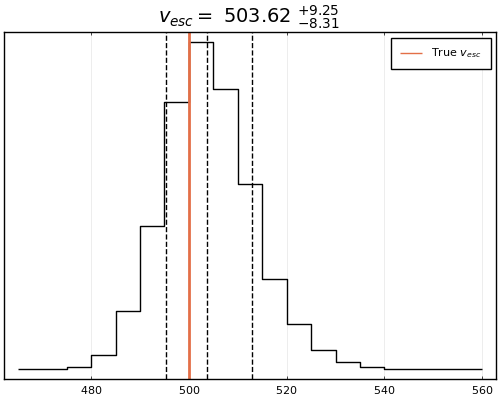

In [25]:
vplot = Plots.plot(vesc_posterior,
            title ="\$v_{esc} =\$ $(@sprintf("%.2f", vesc_median)) \$ ^{+$(@sprintf("%.2f", vesc_upper_1sigma))}_{-$(@sprintf("%.2f", vesc_lower_1sigma))}\$ ",
            #alpha = 0.5,
            seriestype=:stephist,
            bins = 25,
            normed = true,
            #bar_width = 15,
            #linewidth = 0,
            #color = "gray" ,
            lc="black",
            label = "",
            size=(500,400),
            framestyle = :box,
            yticks=false
            )
vline!([target_vesc], lw = 2, label = L"True $v_{esc}$")

vline!(vesc_quantiles , ls=:dash, color="black",lw=1,label="" )

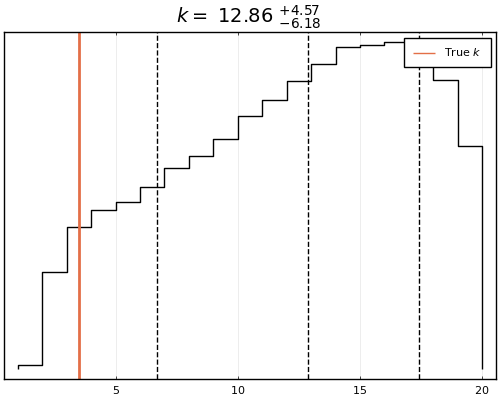

In [26]:
kplot = Plots.plot(k_posterior, normed = true,
                    bins = 25,
                    title = "\$k =\$ $(@sprintf("%.2f", k_median)) \$ ^{+$(@sprintf("%.2f", k_upper_1sigma))}_{-$(@sprintf("%.2f", k_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    framestyle = :box,
                    yticks=false
                    )
vline!([target_k], lw = 2, label = L"True $k$")

vline!( k_quantiles, ls=:dash, color="black",lw=1, label="")

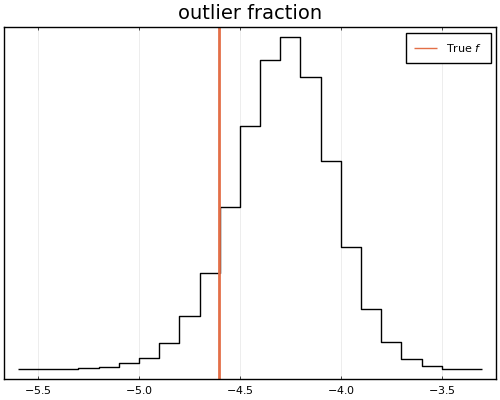

In [34]:
fracplot = Plots.plot(frac_posterior,
            title ="outlier fraction",
            #alpha = 0.5,
            seriestype=:stephist,
            bins = 25,
            normed = true,
            #bar_width = 15,
            #linewidth = 0,
            #color = "gray" ,
            lc="black",
            label = "",
            size=(500,400),
            framestyle = :box,
            yticks=false
            )

vline!([target_frac], lw = 2, label = L"True $f$")

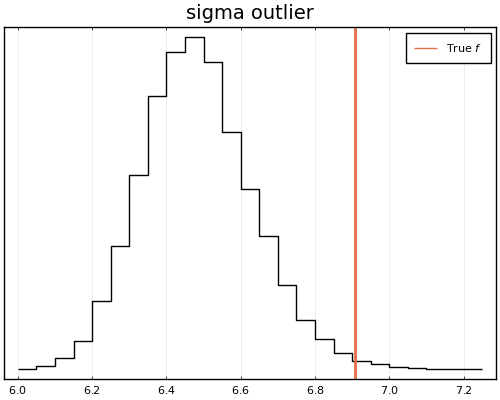

In [35]:
sigma_out_plot = Plots.plot(sigma_out_posterior,
            title ="sigma outlier",
            #alpha = 0.5,
            seriestype=:stephist,
            bins = 25,
            normed = true,
            #bar_width = 15,
            #linewidth = 0,
            #color = "gray" ,
            lc="black",
            label = "",
            size=(500,400),
            framestyle = :box,
            yticks=false
            )

vline!([target_sigma], lw = 2, label = L"True $f$")

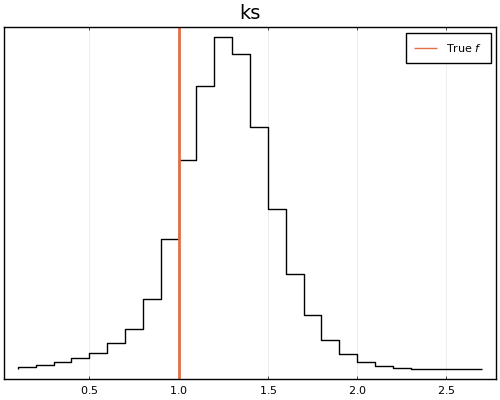

In [36]:
ks_plot = Plots.plot(ks_posterior,
            title ="ks",
            #alpha = 0.5,
            seriestype=:stephist,
            bins = 25,
            normed = true,
            #bar_width = 15,
            #linewidth = 0,
            #color = "gray" ,
            lc="black",
            label = "",
            size=(500,400),
            framestyle = :box,
            yticks=false
            )

vline!([target_ks], lw = 2, label = L"True $ks$")

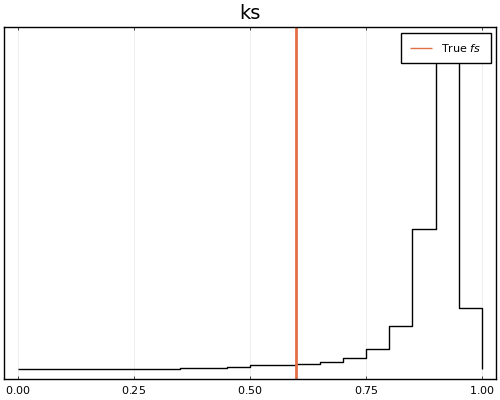

In [37]:
fs_plot = Plots.plot(fs_posterior,
            title ="ks",
            #alpha = 0.5,
            seriestype=:stephist,
            bins = 25,
            normed = true,
            #bar_width = 15,
            #linewidth = 0,
            #color = "gray" ,
            lc="black",
            label = "",
            size=(500,400),
            framestyle = :box,
            yticks=false
            )

vline!([target_fs], lw = 2, label = L"True $fs$")

In [ ]:
using StatsPlots, KernelDensity
dens = kde((vesc_posterior,k_posterior))
p3 = plot(dens,
    #levels = 0.002:0.1:5.0,
    colorbar=false,
    figsize=(400,400),
    xlabel=L"$v_{esc}$",
    ylabel=L"$k$",
    framestyle = :box
    )

vline!([target_vesc], lw = 2,label="")
hline!([target_k], lw = 2,color=2,label="")

In [ ]:
l = @layout [a _ ; b c]

corner = plot(vplot,p3, kplot, layout = l, size=(600,600))

In [ ]:
#savefig(corner, "100000_corner_julia_affine.png")

In [51]:
jobs_dir = "../jobs/"
if edr3
    chains_dir = "../chains_edr3/"
elseif fire
    chains_dir = "../chains/simulations/" * simulation * "/"
else
    chains_dir = "../chains/"
end

gaia_text = ""

if edr3
    print("Reading Gaia EDR3")
    gaia_text = "_edr3_"
elseif fire
    print("Reading FIRE")
    gaia_text = "_fire_" * simulation * "_" * string(lsr) * "_"
end

extratext = ""
extratext *= "lsr_" * string(lsr) * "_"
extratext *= "r_" * string(rgcmin) * "_" * string(rgcmax) * "_z_" * string(z_min) * "_" * string(z_max) * "_vmin" * string(Int(vmin))
extratext *= "_verrcut" * string(verrcut) * error_type
extratext *= preprocessing_cut_type


if ! sausage
    extratext *= "_1func"
end
if random_samples
    extratext *= "_randomsamples"
end
if inverse_vesc_prior
    extratext *= "_inverse_vesc_"
end

Reading FIRE

In [52]:
extratext

"lsr_0_r_7.0_9.0_z_0.0_15.0_vmin350_verrcut0.05percent"

In [ ]:
npzwrite(chains_dir * extratext * ".npy",hcat(vesc_posterior,k_posterior))